<a href="https://colab.research.google.com/github/jeffersonaaron25/DeepLearning-MiniProject-Resnet18/blob/main/notebooks/Deep_Learning_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project - ResNet18 
Project Members: 
Jacob Fishman (jf4322@nyu.edu), Jefferson Aaron Antony Nelsson (ja4568@nyu.edu)

Our aim for the codebase of this project is to create a ResNet that would be able to perform well on the CIFAR-10 dataset. Our code and reasoning will be documented throughout this workbook

We first will add all of the packages that we will need for this project. If you are looking to run this code you must make sure your machine has these packages available. 

In [ ]:
#These are the packages that we loaded in from Homework 2 problem 4 where we worked with the same dataset and created an AlexNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random


We will now set a random seed for the project, like we did in Homework 2 Problem 4 when we examined the same dataset

In [ ]:
#The following code is from Homework 2 Problem 4


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Loading the Dataset**
We will now use the same technique we used in Homework 2 Problem 4 to load the dataset into memory.

In [ ]:
#The following code is from Homework 2 Problem 4

ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12238877.01it/s]


Extracting .data/cifar-10-python.tar.gz to .data


We will now do data augmentation on the train dataset, and also adjust the colors of the images by normalizing using the mean and standard deviation. We got the idea to do this from Class and Homework 2 Problem 4

In [ ]:
#The following code is from Homework 2 Problem 4

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

train_transforms = transforms.Compose([
                           transforms.RandomRotation(10),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

We now will load the train dataset and the test dataset into memory. We will use the above transformations on the datasets as well.

In [ ]:
#The following code is from Homework 2 Problem 4

train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#The following code is from Homework 2 Problem 4

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We will now use the normalize image function from Homework 2 Problem 4 to help us normalize an image throughout this process

In [ ]:
#The following code is from Homework 2 Problem 4


def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

We are now going to assign the Batch Size for the ResNet

In [ ]:
#Here we are using the torch utils function dataloader, which lets us use the batch size for the data loader
#This will let us load the data to use for the training in the ResNet

BATCH_SIZE = 128 #Here you can change the batch size. Try to keep it in a power of 2, eg 2^2, 2^3 etc

#adding shuffle=True for randomness
train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# **Building the Model**
We are now going to build the ResNet, using code from the repository that was linked in the project description:

https://github.com/kuangliu/pytorch-cifar

We are using the code from the folder models, with the pathway 
kuangliu /pytorch-cifar/models/resnet.py



In [ ]:
#The following class was used from the github link above.
#We claim no ownership over the code

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) #Here is where we can change the kernal size, stride, and padding
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)  #Here is where we can change the kernal size, stride, and padding
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
          

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#The following class was used from the github link above.
#We claim no ownership over the code

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) #Here we can change the output size from the initial block
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)#Here we can change the output size from the initial block
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)#Here we can change the output size from the initial block
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = F.avg_pool2d(out, 7) #Here we can change the pooling by adding more of these lines to the forward pass
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
#We now need to create a variable to hold the instant of the model
#We will use the defalut inputs to the model that were in the 
#Code from the codebase in github: https://github.com/kuangliu/pytorch-cifar

model = ResNet(BasicBlock, [3,2,3]) #This lets you change the number of layers in each block. This setting gets the parameters below 5M


Now we will use the code from Homework 2 Question 4 to define the learning rate, the loss function, and the device we will use for the model

In [ ]:
#The following code is from Homework 2 Problem 4

optimizer = optim.Adam(model.parameters(), lr = 0.00025)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


In [ ]:
#In order to check the number of trainable parameters, we will use the torchsummary package

import torchsummary

torchsummary.summary(model,(3, 28, 28), 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 64, 28, 28]           1,728
       BatchNorm2d-2          [256, 64, 28, 28]             128
            Conv2d-3          [256, 64, 28, 28]          36,864
       BatchNorm2d-4          [256, 64, 28, 28]             128
            Conv2d-5          [256, 64, 28, 28]          36,864
       BatchNorm2d-6          [256, 64, 28, 28]             128
        BasicBlock-7          [256, 64, 28, 28]               0
            Conv2d-8          [256, 64, 28, 28]          36,864
       BatchNorm2d-9          [256, 64, 28, 28]             128
           Conv2d-10          [256, 64, 28, 28]          36,864
      BatchNorm2d-11          [256, 64, 28, 28]             128
       BasicBlock-12          [256, 64, 28, 28]               0
           Conv2d-13          [256, 64, 28, 28]          36,864
      BatchNorm2d-14          [256, 64,

# **Create Training modules**
We will now use the boilerplate code from class to help train and calculate the loss and accuracy of each training epoch

In [ ]:
#The following code is from Homework 2 Problem 4
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#The following code is from Homework 2 Problem 4
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        #print(x.shape)

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#The following code is from Homework 2 Problem 4

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#The following code is from Homework 2 Question 4
#There have been modifications to the code with the answers 
#From Jacob Fishman's Code that he submitted for the problem

# Print out training and validation loss/accuracy of the model after each epoch
# Keep track of the model that achieved best validation loss thus far.

EPOCHS = 75
train_loss = []
test_loss = []
epoch = []

#I first want to create the variables to hold the best model for use later
best_model = None
best_loss = float('inf')

for i in range(EPOCHS):

  #I will loop over for the number of epochs, and each time i will use the defined train and evaluate
  #classes that were provided to us. 
  train_epoch_loss, train_epoch_acc = train(model,train_iterator,optimizer,criterion,device)
  vaild_epoch_loss, valid_epoch_acc = evaluate(model,valid_iterator, criterion,device)
  test_epoch_loss, test_epoch_acc = evaluate(model,test_iterator, criterion,device)
  train_loss.append(train_epoch_loss)
  test_loss.append(test_epoch_loss)
  epoch.append(i)
  #Now i will print out the valid loss and accuracy 
  print(f'Epoch: {i+1:02}')
  print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.2f}%')
  print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.2f}%')
  
  #Here I will save the best model based off of validation loss

  if best_model == None: 
    best_model = torch.save(model.state_dict(),'tensor.pth')
    best_loss = vaild_epoch_loss
  elif vaild_epoch_loss < best_loss: #can't we just have this condition to store the best model?
    best_model = torch.save(model.state_dict(),'tensor.pth')
    best_loss = vaild_epoch_loss


Epoch: 01
	Train Loss: 1.325 | Train Acc: 51.86%
	 Val. Loss: 1.094 |  Val. Acc: 61.97%
Epoch: 02
	Train Loss: 0.891 | Train Acc: 68.73%
	 Val. Loss: 0.879 |  Val. Acc: 70.33%
Epoch: 03
	Train Loss: 0.717 | Train Acc: 75.06%
	 Val. Loss: 0.833 |  Val. Acc: 72.19%
Epoch: 04
	Train Loss: 0.614 | Train Acc: 78.65%
	 Val. Loss: 0.764 |  Val. Acc: 74.20%
Epoch: 05
	Train Loss: 0.546 | Train Acc: 81.15%
	 Val. Loss: 0.611 |  Val. Acc: 79.51%
Epoch: 06
	Train Loss: 0.495 | Train Acc: 82.98%
	 Val. Loss: 0.542 |  Val. Acc: 81.50%
Epoch: 07
	Train Loss: 0.447 | Train Acc: 84.45%
	 Val. Loss: 0.543 |  Val. Acc: 81.48%
Epoch: 08
	Train Loss: 0.412 | Train Acc: 85.65%
	 Val. Loss: 0.506 |  Val. Acc: 82.75%
Epoch: 09
	Train Loss: 0.383 | Train Acc: 86.70%
	 Val. Loss: 0.458 |  Val. Acc: 84.16%
Epoch: 10
	Train Loss: 0.362 | Train Acc: 87.39%
	 Val. Loss: 0.537 |  Val. Acc: 81.84%
Epoch: 11
	Train Loss: 0.335 | Train Acc: 88.34%
	 Val. Loss: 0.468 |  Val. Acc: 85.12%
Epoch: 12
	Train Loss: 0.314 | T

Now we will plot the training loss with the testing loss over epochs to make sure we are not overfitting the model

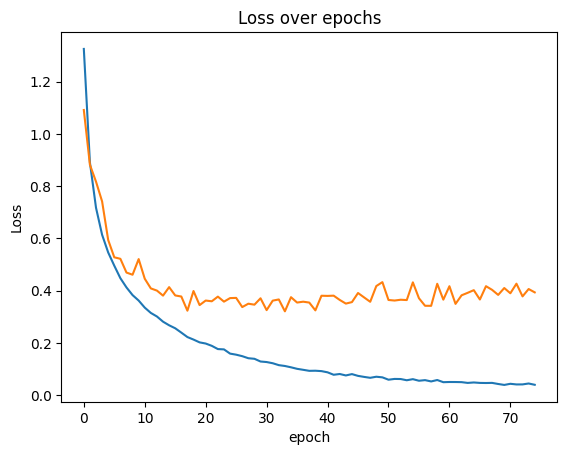

In [ ]:
plt.plot(epoch, train_loss, label="train loss")
plt.plot(epoch,test_loss, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

# **Testing the Best Model**
Here we will load in the best model to memory and use it to test on the test set

In [ ]:
#First we will load the best model by creating an instance of the model then loading the weights into the 
#dummy model
best_model = ResNet(BasicBlock, [3,2,3])
best_model.load_state_dict(torch.load('tensor.pth'))

#Now I will run the best model on the test data
best_model = best_model.to(device)
test_epoch_loss, test_epoch_acc = evaluate(best_model,test_iterator, criterion,device)
print(f'Test Loss: {test_epoch_loss:.3f} | Test Acc: {test_epoch_acc*100:.2f}%')

Test Loss: 0.393 | Test Acc: 91.46%


In [ ]:
#This code is used in Homework 2 Question 4, with the filled out sections by us

def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)
            
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)


In [ ]:
#This code block is from the Homework2 Question 4
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

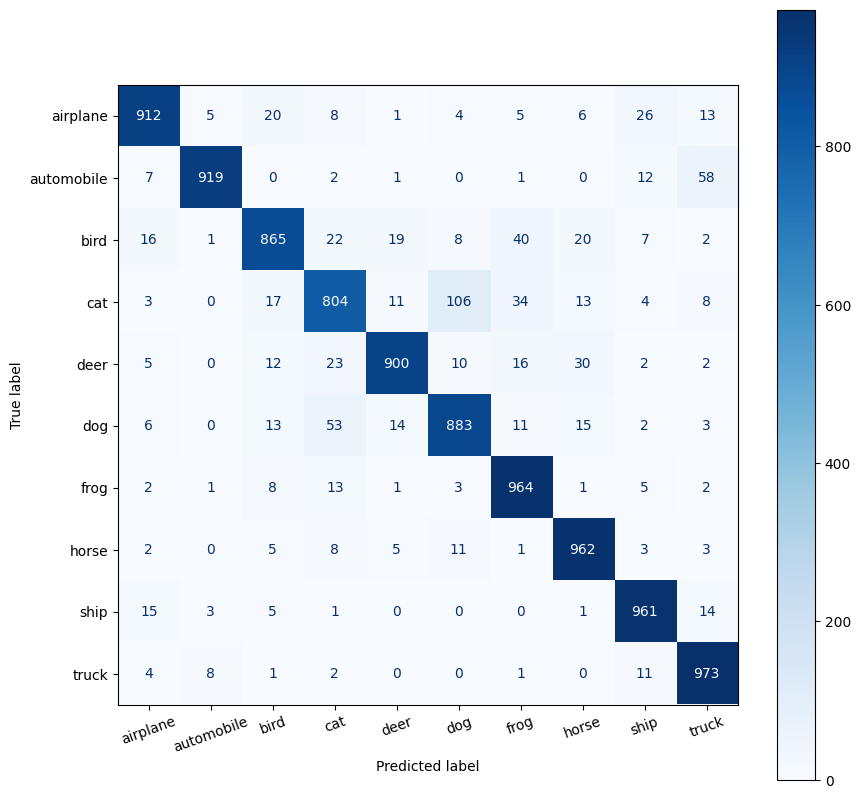

In [ ]:
classes = test_data.classes
labels = labels.to("cpu")
pred_labels = pred_labels.to("cpu")
plot_confusion_matrix(labels, pred_labels, classes) 